# Interpolation and Curve Fitting




## Interpolation

* Given a set of $x$ and $y$ points, estimate intermediate values.
* This is normally done be fitting a function to *local* points and then using the function to evaluate the desired points.
* Example, given a set of points on a nonuniform grid, interpolate values to a uniform grid.
* Interpolation will deal with 4 sets of data: 
    * **Given:** $x_{\text{given}}$, $y_{\text{given}}$, $x_{\text{desired}}$ 
    * **Find:** $y_{\text{desired}}$.  
    



### Linear interpolation

* For a given $x_d$ ("d" for "desired"), you need to find your neighborhood. 
    * Find the two nearest values of the given data $x_g$ that bracket $x_d$.
    * Really, you are finding the two list indicies of $x_g$ that bracket $x_d$.
    * Call these indices $i_{lo}$ and $i_{hi}$.
* The equation for the line through the given bracketing points is

$$y = y_g[i_{lo}] + (x - x_g[i_{lo}])\frac{y_g[i_{hi}]-y_g[i_{lo}]}{x_g[i_{hi}]-x_g[i_{lo}]}.$$

* Evaluate this at $x=x_d$ to get $y_d$:

<font color='blue'>
$$y_d = y_g[i_{lo}] + (x_d - x_g[i_{lo}])\frac{y_g[i_{hi}]-y_g[i_{lo}]}{x_g[i_{hi}]-x_g[i_{lo}]}.$$
</font>
    



#### Extrapolation

* If $x_d<x[0]$, then $i_{lo}=0$ and $i_{hi}=1$. 
* If $x_d>x[n-1]$, (for $n$ given points), then $i_{lo}=n-2$ and $i_{hi}=n-1$.
* The above formula still works, but $x_d$ is not bracketed. We call this extrapolation.



#### Python

* Python has a built in interpolator called interp1d.
* This will interpolate a 1-D array.




#### Example

* Take given x data as 10 linearly spaced points between 0 and 10.
* Take given y data from the function $\cos(x^2/8)$.

In [10]:
using Plots
using Interpolations
using PyFormattedStrings
using Random

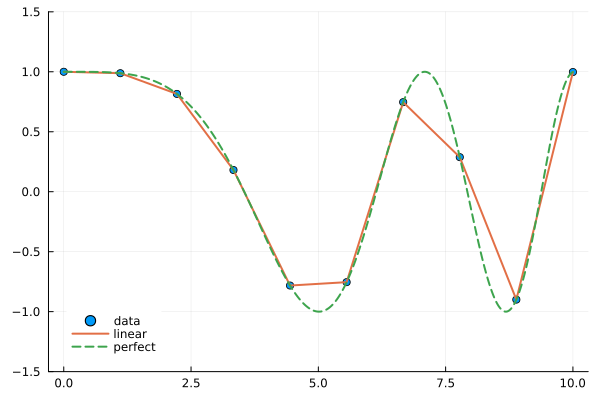

In [11]:
function plot_a()
    xg = LinRange(0,10,10)         # Interpolate between the given data
    yg = cos.(xg.^2.0/8.0)      
    xx = LinRange(0,10,1000)       # for plotting
    yy = cos.(xx.^2.0/8.0)         # for plotting
    
    x_i = LinRange(0,10,100)        # interpolate to these points.
    
    #------- Linear interpolation  
    
    f_linear   = LinearInterpolation(xg, yg)  # get interpolation function
    y_i_linear = f_linear(x_i)                # interpolate to y_i at x_i
    
    #------- Plot the results
    
    scatter(xg,yg,        lw=2, label="data")
    plot!(x_i,y_i_linear, lw=2, label="linear")
    plot!(xx, yy,         lw=2, label="perfect", linestyle=:dash,  )
    plot!(legend_foreground_color=nothing)
    plot!(ylim=[-1.5,1.5])
end
plot_a()

### Cubic Splines

* Cubic splines give a higher order local fit to the data points.
* Fit a cubic polynomial for region $i$ to two adjacent data points $x_i$ and $x_{i+1}$
$$p_i(x) = a_i + b_i x + c_ix^2 + d_ix^3.$$

* Suppose we have a list of 5 points $x_0$ through $x_4$, with corresponding $y_0$ through $y_4$.
* There are four intervals on which splines are defined.



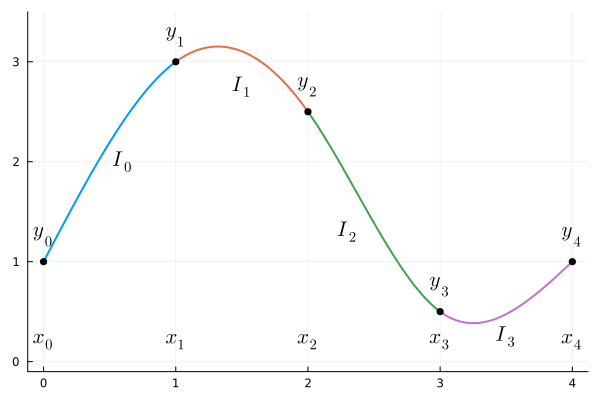

In [12]:
function plot_b()
    xg = LinRange(0,4,5)
    yg = [1,3,2.5,0.5,1]
    fs = CubicSplineInterpolation(xg, yg) #, kind='cubic')
    
    plot()
    for i in 0:3
        xx = LinRange(i,i+1,1000)
        plot!(xx, fs.(xx), lw=2)
    end
    scatter!(xg,yg, color="black")
    plot!(ylim=[-0.1,3.5])
    
    i=0; annotate!(i+0.6, 0.5*(fs(i)+fs(i+1))-0.0, "\$I_$i\$")
    i=1; annotate!(i+0.5, 0.5*(fs(i)+fs(i+1))-0.0, "\$I_$i\$")
    i=2; annotate!(i+0.3, 0.5*(fs(i)+fs(i+1))-0.2, "\$I_$i\$")
    i=3; annotate!(i+0.5, 0.5*(fs(i)+fs(i+1))-0.5, "\$I_$i\$")
    for i in 0:4
        annotate!(i, 0.2, "\$x_$i\$")
    end
    for i in 0:4
        annotate!(i, fs(i)+0.25, "\$y_$i\$")
    end
    
    plot!(legend=nothing)
end
plot_b()

* Again, we have 5 points and 4 splines.
* Each spline has 4 coefficients, so we have **16 degrees of freedom**.
* Need **16 constraints** to specify the splines and solve for the spline polynomial coefficients.
    * Each spline passes through two points: **8**
    * Let the derivative $p^{\prime}(x)$ be continuous at the spline interfaces: **3**
    * Let the second derivative also be continuous at the spline interfaces: **3**
    * This gives 14 constraints. We need two more.
        * Specify $p^{\prime\prime}(x)$ at the two ends: **2**.
* This results in a linear system of equations that can be solved directly.
* Hoffman and Press et al. (Numerical Recipies) reformulate the equations in a manner that gives a tridiagonal system of equations. 
* Note that the whole domain is coupled when solving the splines, and all of the splines are solved together.



### Equations
* Hoffman p. 221 and Numerical Recipes p. 120 give details of the equations.

A general cubic equation is given by
$$f(x) = ax^3 + bx^2 + cx + d.$$
The second derivative is
$$f^{\prime\prime}(x) = 6ax + b,$$
which is a linear profile. Hence, the second derivative profile can be written as 
$$f^{\prime\prime} = Af_i^{\prime\prime} + Bf_{i+1}^{\prime\prime},$$
where
$$A = \frac{x_{i+1}-x}{x_{i+1}-x_i},$$
$$B = 1-A = \frac{x-x_i}{x_{i+1}-x_i}.$$
If we integrate this twice, we get an expression for $f(x)$ and $f^\prime(x)$, with two constants of integration. These constants are evaluated by requiring that $f(x) = f(x_i)$ and the two end points of a given spline. This results in the following spline equation:
<font color="blue">
    $$f(x) = \frac{f_i^{\prime\prime}}{6(x_{i+1}-x_i)}(x_{i+1}-x)^3 + 
    \frac{f_{i+1}^{\prime\prime}}{6(x_{i+1}-x_i)}(x-x_i)^3 + 
    \\
    \left[\frac{f_i}{x_{i+1}-x_i} -\frac{f_i^{\prime\prime}(x_{i+1}-x_i)}{6}\right](x_{i+1}-x) + 
    \\
    \left[\frac{f_{i+1}}{x_{i+1}-x_i} -\frac{f_{i+1}^{\prime\prime}(x_{i+1}-x_i)}{6}\right](x-x_i)$$
</font>
This equation is used to evaluate the spline. But it is in terms of the second derivatives at the node points, which need to be evaluated. That evaluation is done by equating the first derivative between neighboring splines. This yeilds a tridiagonal system for the second derivatives:
<font color="blue">
    $$(x_i - x_{i-1})f_{i_1}^{\prime\prime} + 2(x_{i+1}-x_{i-1})f_i^{\prime\prime} + (x_{i+1}-x_i)f_{i+1}^{\prime\prime} = 6\frac{f_{i+1}-f_i}{x_{i+1}-x_i} - 6\frac{f_i-f_{i-1}}{x_i-x_{i-1}},$$
</font>
which can be solved using the Thomas Algorithm.
* Note, the boundary values of $f^{\prime\prime}$ are needed, and these are usually set to zero.


### Python

* For cubic splines, just add the keyword: kind='cubic' to the interp1d function call.

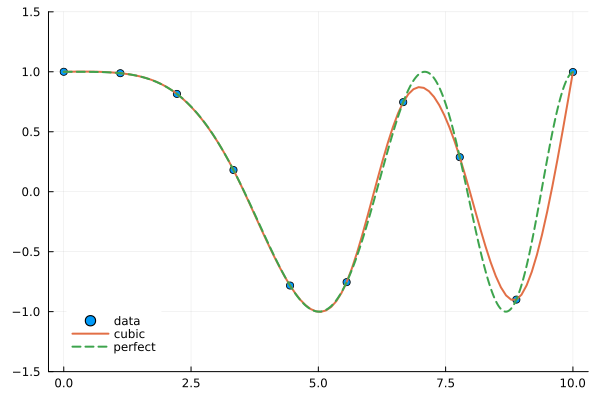

In [13]:
function plot_c()
    xg = LinRange(0,10,10)    # Interpolate between the given data
    yg = cos.(xg.^2.0/8.0)      
    xx = LinRange(0,10,1000)  # for plotting
    yy = cos.(xx.^2.0/8.0)     # for plotting
    
    x_i = LinRange(0,10,100)  # interpolate to these points.
    
    #------- Linear interpolation  
    
    f_cubic    = CubicSplineInterpolation(xg, yg)   # get an interpolation function
    y_i_cubic = f_cubic.(x_i)        # interpolate to y_i at x_i
    
    #------- Plot the results
    
    scatter(xg,yg,        lw=2, label="data")
    plot!(x_i,y_i_cubic,  lw=2, label="cubic")
    plot!(xx, yy,         lw=2, label="perfect", linestyle=:dash,  )
    plot!(legend_foreground_color=nothing)
    plot!(ylim=[-1.5,1.5])
end
plot_c()

## Find your location
* To apply linear interpolation at a given point, we first need to find the location of $x_d$ in the list. 
    * That is, we need $i_{lo}$ and $i_{hi}$. 
* Interpolation routines will assume the $x$ data are monotonically increasing or decreasing, and will issue an error otherwise.
* Two cases:
    1. Uniformly spaced points,
        * (or some other analytic spacing)
    2. Arbitrarily spaced points.

### Case 1: Uniform points

In [14]:
function locate_uniform(x, xd)
    Δx = x[2]-x[1]
    ilo = Integer(floor((xd-x[1])/Δx))+1
    ihi = ilo+1
    if ilo < 0
        return 1,2
    end
    if ihi >= length(x)
        return length(x)-1, length(x)
    end
    return ilo, ihi
end;

In [15]:
x = LinRange(2, 5, 7)

for i in 1:length(x)
    println(f"{i}, {x[i]:.1f}")
end

xd = 3.7
(ilo, ihi) = locate_uniform(x, xd)

println(f"\nilo={ilo}, ihi={ihi} bracket point x={xd}")

1, 2.0
2, 2.5
3, 3.0
4, 3.5
5, 4.0
6, 4.5
7, 5.0

ilo=4, ihi=5 bracket point x=3.7


### Case 2: Arbitrarily spaced points
* Many approaches are possible.
* Press et al. advocate using bisection.
* Finds location in $\log_2N$ tries.

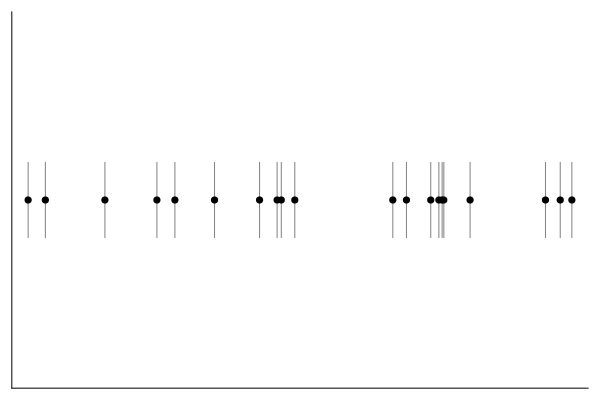

In [17]:
x = rand(20)
sort!(x)

plot()
for xx in x
    plot!([xx,xx],[0.4,0.6], color="gray")
    scatter!([xx],[0.5], color="black")
end
plot!(ylim=[0,1], legend=nothing, axis=nothing)

In [19]:
function getLoc(xx, x)                 # bisection, from Numerical Recipes
    n = length(xx)
    jl, ju = 0, n-1
    while ju-jl > 1 
        jm = (ju + jl) >> 1       # same as int((ju+jl)/2)
        if x >=xx[jm] 
            jl = jm
        else 
            ju = jm
        end
    end
    return jl, ju
end

getLoc(x, 0.5)

(9, 10)